In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2018,12,31) #dt.datetime(2019,6,30)

In [3]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [4]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [5]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [6]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [7]:
def logt(x):
    return np.log10(x+.001)

In [8]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [9]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

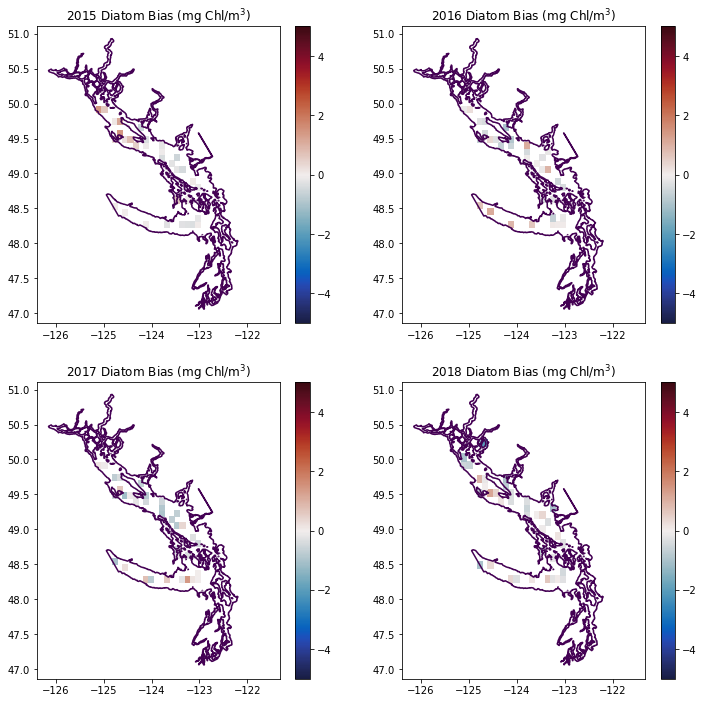

In [10]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Diatom Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*dyr['mod_diatoms'])-logt(dyr['Diatoms-1']+dyr['Diatoms-2']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

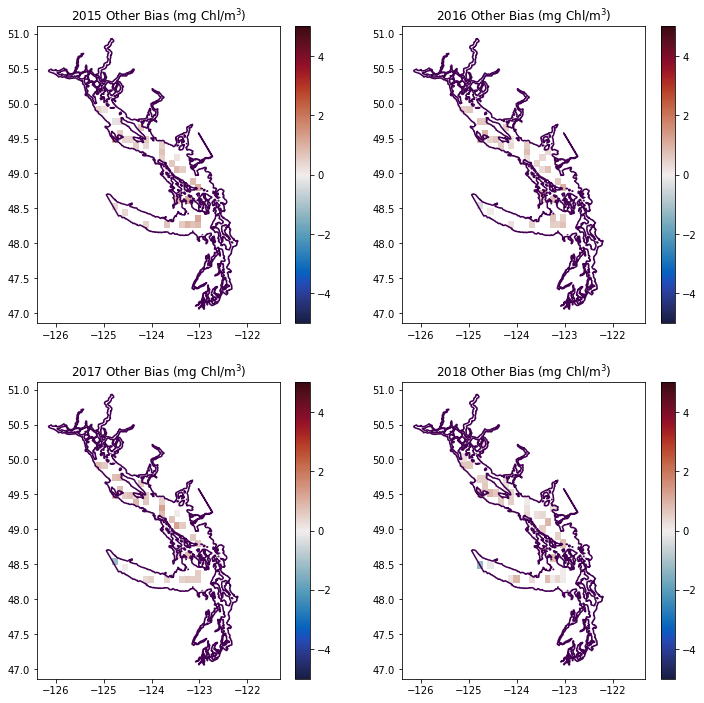

In [11]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Other Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*(dyr['mod_flagellates']+dyr['mod_ciliates']))-logt(dyr['other']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

### Regions

In [12]:
r1=data.Lat>49.4
r2=(data.Lat<49.4)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.5)&(data.Lon<-123.5)

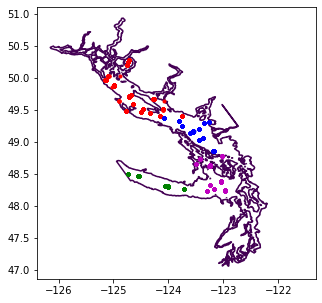

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax.plot(data.loc[r1,['Lon']].values,data.loc[r1,['Lat']].values,'r.')
ax.plot(data.loc[r2,['Lon']].values,data.loc[r2,['Lat']].values,'b.')
ax.plot(data.loc[r3,['Lon']].values,data.loc[r3,['Lat']].values,'m.')
ax.plot(data.loc[r4,['Lon']].values,data.loc[r4,['Lat']].values,'g.')

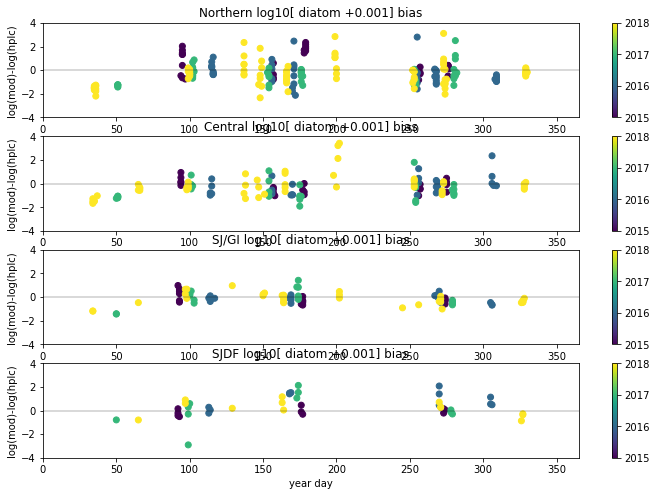

In [14]:
fig,ax=plt.subplots(4,1,figsize=(12,8))

xx=data.loc[r1,['yd']].values
yy=logt(1.8*(data.loc[r1,['mod_diatoms']].values))-logt(data.loc[r1,['Diatoms-1']].values+data.loc[r1,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r1[ind]]
m=ax[0].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[0])
ax[0].set_title('Northern log10[ diatom +0.001] bias')
ax[0].set_xlabel('year day')
ax[0].set_ylabel('log(mod)-log(hplc)')
ax[0].set_ylim(-4,4)

r=r2
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[1].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[1])
ax[1].set_title('Central log10[ diatom +0.001] bias')
ax[1].set_xlabel('year day')
ax[1].set_ylabel('log(mod)-log(hplc)')
ax[1].set_ylim(-4,4)

r=r3
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[2].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[2])
ax[2].set_title('SJ/GI log10[ diatom +0.001] bias')
ax[2].set_xlabel('year day')
ax[2].set_ylabel('log(mod)-log(hplc)')
ax[2].set_ylim(-4,4)

r=r4
xx=data.loc[r,['yd']].values
yy=logt(1.8*(data.loc[r,['mod_diatoms']].values))-logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
colors=[ii.year for ind,ii in zip(range(0,len(data['dtUTC'])),data['dtUTC']) if r[ind]]
m=ax[3].scatter(xx[:,0],yy[:,0],c=colors)
fig.colorbar(m,ax=ax[3])
ax[3].set_title('SJDF log10[ diatom +0.001] bias')
ax[3].set_xlabel('year day')
ax[3].set_ylabel('log(mod)-log(hplc)')
ax[3].set_ylim(-4,4)

for iax in range(0,4):
    ax[iax].plot((0,365),(0,0),'k-',alpha=.2)
    ax[iax].set_xlim((0,365))

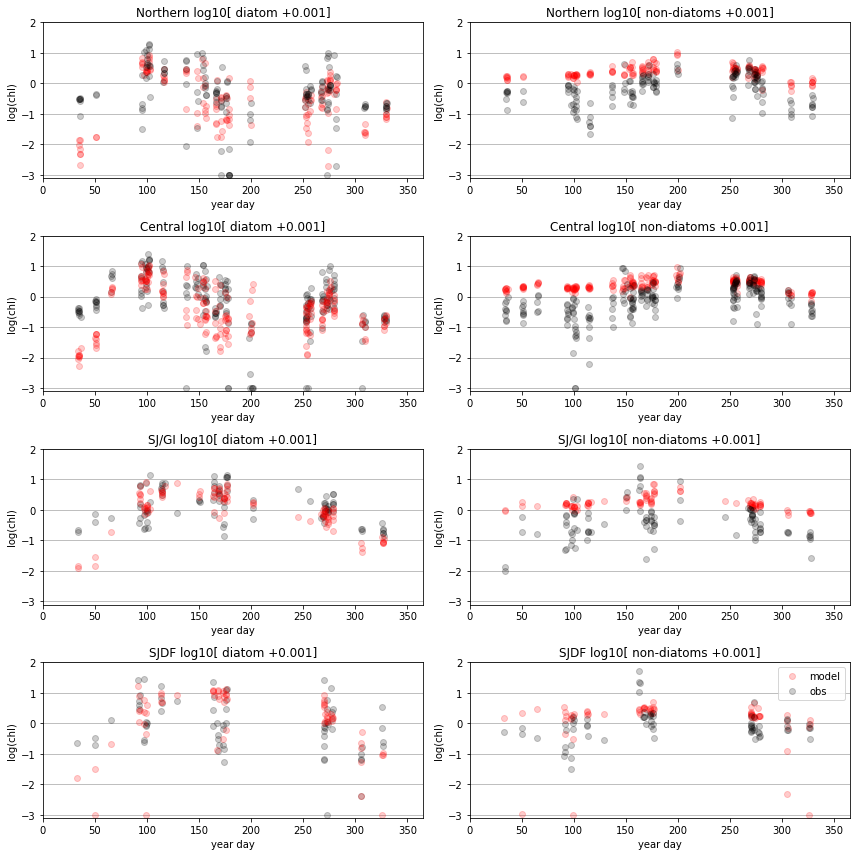

In [15]:
fig,ax=plt.subplots(4,2,figsize=(12,12))
ax=ax.flatten()
r0=(data['mod_diatoms']>=0)&(data['Diatoms-1']>=0)&(data['Diatoms-2']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_diatoms']].values))
yy2=logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' log10[ diatom +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r2&r0; iax=ax[2]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_diatoms']].values))
yy2=logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.set_title(loc+' log10[ diatom +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r3&r0; iax=ax[4]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_diatoms']].values))
yy2=logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.set_title(loc+' log10[ diatom +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r4&r0;iax=ax[6]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_diatoms']].values))
yy2=logt(data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.set_title(loc+' log10[ diatom +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r0=(data['mod_flagellates']>=0)&(data['mod_ciliates']>=0)&(data['other']>=0)

r=r1&r0; iax=ax[1]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values))
yy2=logt(data.loc[r,['other']].values)
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' log10[ non-diatoms +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r2&r0; iax=ax[3]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values))
yy2=logt(data.loc[r,['other']].values)
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' log10[ non-diatoms +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r3&r0; iax=ax[5]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values))
yy2=logt(data.loc[r,['other']].values)
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' log10[ non-diatoms +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')

r=r4&r0;iax=ax[7]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=logt(1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values))
yy2=logt(data.loc[r,['other']].values)
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' log10[ non-diatoms +0.001]')
iax.set_xlabel('year day')
iax.set_ylabel('log(chl)')
iax.grid(axis='y')
iax.legend()

for iax in range(0,8):
    ax[iax].set_xlim((0,365))
    ax[iax].set_ylim(-3.1,2)

plt.tight_layout()

### by year

2015


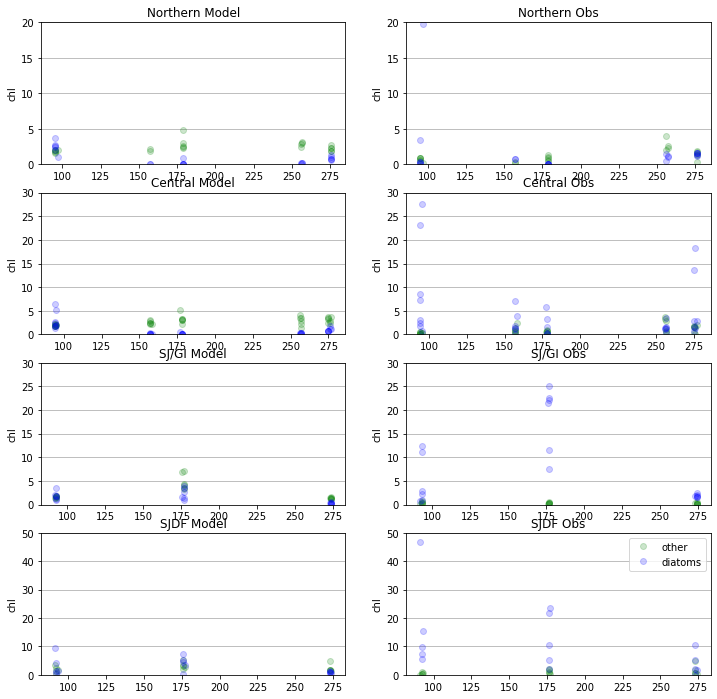

In [16]:
data1=data.loc[data.Year==2015]
print(2015)
fig,ax=plt.subplots(4,2,figsize=(12,12))
ax=ax.flatten()

r0=(data1['mod_flagellates']>=0)&(data1['mod_ciliates']>=0)&(data1['other']>=0)&(data1['mod_diatoms']>=0)&(data1['Diatoms-1']>=0)&(data1['Diatoms-2']>=0)
r1=(data1.Lat>49.5)
r2=(data1.Lat<49.5)&(data1.Lat>48.8)
r3=(data1.Lat<48.8)&(data1.Lon>-123.5)
r4=(data1.Lat<48.8)&(data1.Lon<-123.5)

r=r1&r0; iax=ax[0]; loc='Northern Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r1&r0; iax=ax[1]; loc='Northern Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r2&r0; iax=ax[2]; loc='Central Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r2&r0; iax=ax[3]; loc='Central Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[4]; loc='SJ/GI Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[5]; loc='SJ/GI Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r4&r0;iax=ax[6]; loc='SJDF Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,50)

r=r4&r0;iax=ax[7]; loc='SJDF Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.legend()
iax.set_ylim(0,50)

for ii in range(0,8):
    ax[ii].grid(axis='y')
    ax[ii].set_ylabel('chl')

2016


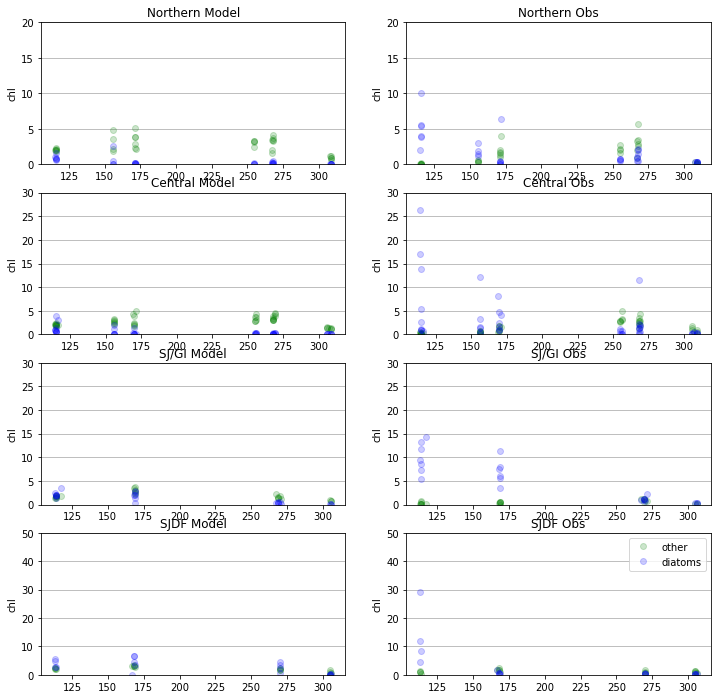

In [17]:
data1=data.loc[data.Year==2016]
print(2016)
fig,ax=plt.subplots(4,2,figsize=(12,12))
ax=ax.flatten()

r0=(data1['mod_flagellates']>=0)&(data1['mod_ciliates']>=0)&(data1['other']>=0)&(data1['mod_diatoms']>=0)&(data1['Diatoms-1']>=0)&(data1['Diatoms-2']>=0)
r1=(data1.Lat>49.5)
r2=(data1.Lat<49.5)&(data1.Lat>48.8)
r3=(data1.Lat<48.8)&(data1.Lon>-123.5)
r4=(data1.Lat<48.8)&(data1.Lon<-123.5)

r=r1&r0; iax=ax[0]; loc='Northern Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r1&r0; iax=ax[1]; loc='Northern Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r2&r0; iax=ax[2]; loc='Central Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r2&r0; iax=ax[3]; loc='Central Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[4]; loc='SJ/GI Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[5]; loc='SJ/GI Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r4&r0;iax=ax[6]; loc='SJDF Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,50)

r=r4&r0;iax=ax[7]; loc='SJDF Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.legend()
iax.set_ylim(0,50)

for ii in range(0,8):
    ax[ii].grid(axis='y')
    ax[ii].set_ylabel('chl')

2017


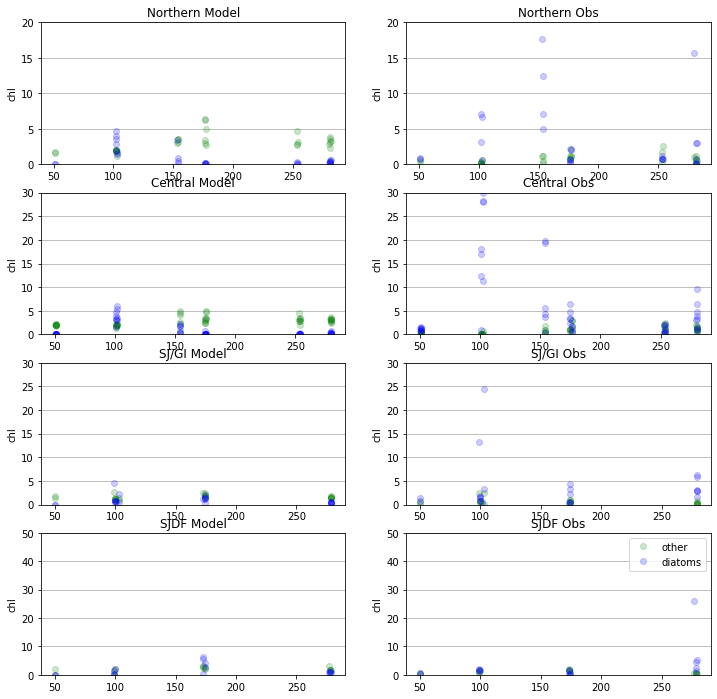

In [18]:
data1=data.loc[data.Year==2017]
print(2017)
fig,ax=plt.subplots(4,2,figsize=(12,12))
ax=ax.flatten()

r0=(data1['mod_flagellates']>=0)&(data1['mod_ciliates']>=0)&(data1['other']>=0)&(data1['mod_diatoms']>=0)&(data1['Diatoms-1']>=0)&(data1['Diatoms-2']>=0)
r1=(data1.Lat>49.5)
r2=(data1.Lat<49.5)&(data1.Lat>48.8)
r3=(data1.Lat<48.8)&(data1.Lon>-123.5)
r4=(data1.Lat<48.8)&(data1.Lon<-123.5)

r=r1&r0; iax=ax[0]; loc='Northern Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r1&r0; iax=ax[1]; loc='Northern Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r2&r0; iax=ax[2]; loc='Central Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r2&r0; iax=ax[3]; loc='Central Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[4]; loc='SJ/GI Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[5]; loc='SJ/GI Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r4&r0;iax=ax[6]; loc='SJDF Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,50)

r=r4&r0;iax=ax[7]; loc='SJDF Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.legend()
iax.set_ylim(0,50)

for ii in range(0,8):
    ax[ii].grid(axis='y')
    ax[ii].set_ylabel('chl')

2018


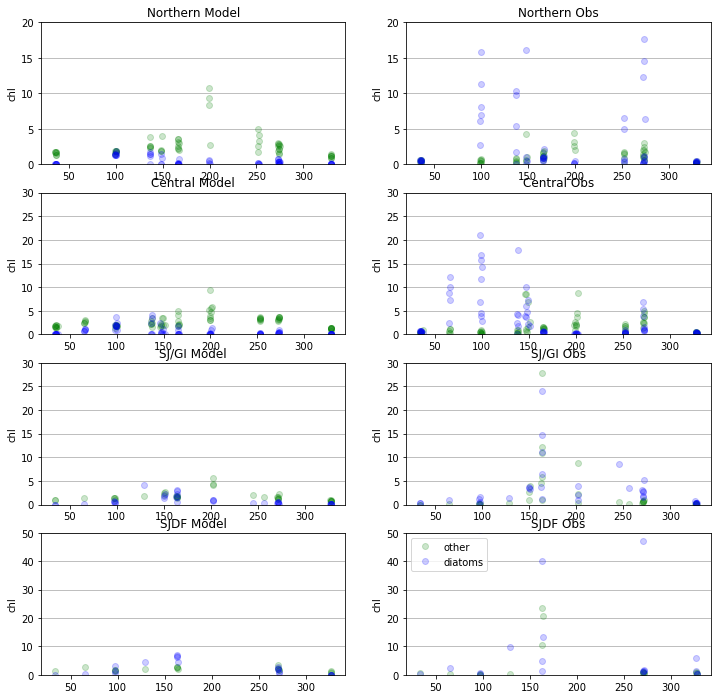

In [19]:
data1=data.loc[data.Year==2018]
print(2018)
fig,ax=plt.subplots(4,2,figsize=(12,12))
ax=ax.flatten()

r0=(data1['mod_flagellates']>=0)&(data1['mod_ciliates']>=0)&(data1['other']>=0)&(data1['mod_diatoms']>=0)&(data1['Diatoms-1']>=0)&(data1['Diatoms-2']>=0)
r1=(data1.Lat>49.5)
r2=(data1.Lat<49.5)&(data1.Lat>48.8)
r3=(data1.Lat<48.8)&(data1.Lon>-123.5)
r4=(data1.Lat<48.8)&(data1.Lon<-123.5)

r=r1&r0; iax=ax[0]; loc='Northern Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r1&r0; iax=ax[1]; loc='Northern Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,20)

r=r2&r0; iax=ax[2]; loc='Central Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r2&r0; iax=ax[3]; loc='Central Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[4]; loc='SJ/GI Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r3&r0; iax=ax[5]; loc='SJ/GI Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,30)

r=r4&r0;iax=ax[6]; loc='SJDF Model'
xx=data1.loc[r,['yd']].values
yy1=1.8*(data1.loc[r,['mod_flagellates']].values+data1.loc[r,['mod_ciliates']].values)
yy2=data1.loc[r,['mod_diatoms']].values
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.set_ylim(0,50)

r=r4&r0;iax=ax[7]; loc='SJDF Obs'
xx=data1.loc[r,['yd']].values
yy1=data1.loc[r,['other']].values
yy2=1.8*(data1.loc[r,['Diatoms-1']].values+data1.loc[r,['Diatoms-2']].values)
iax.plot(xx[:,0],yy1[:,0],'go',alpha=.2,label='other')
iax.plot(xx[:,0],yy2[:,0],'bo',alpha=.2,label='diatoms')
iax.set_title(loc)
iax.legend()
iax.set_ylim(0,50)

for ii in range(0,8):
    ax[ii].grid(axis='y')
    ax[ii].set_ylabel('chl')

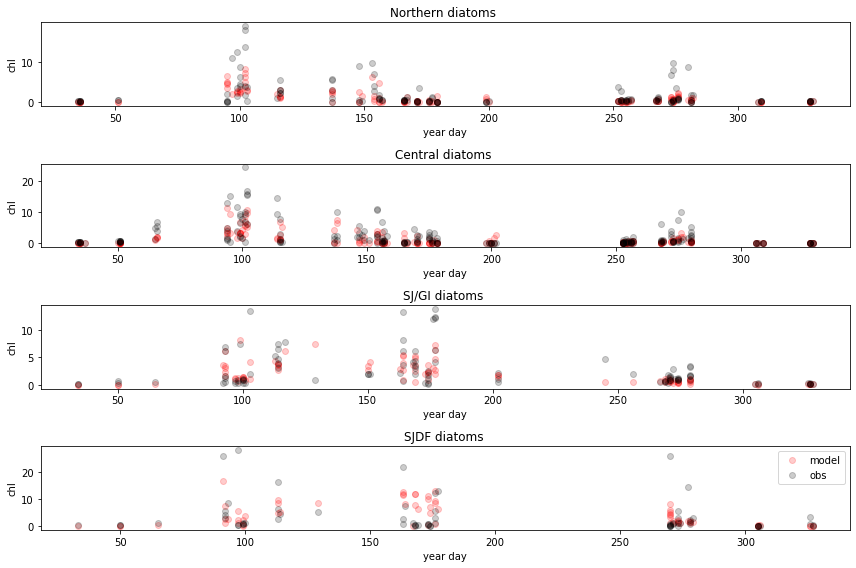

In [20]:
fig,ax=plt.subplots(4,1,figsize=(12,8))
r0=(data['mod_diatoms']>=0)&(data['Diatoms-1']>=0)&(data['Diatoms-2']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms ')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r2&r0; iax=ax[1]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms ')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r3&r0; iax=ax[2]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms ')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r4&r0;iax=ax[3]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms ')
iax.set_xlabel('year day')
iax.set_ylabel('chl')
iax.legend()

plt.tight_layout()

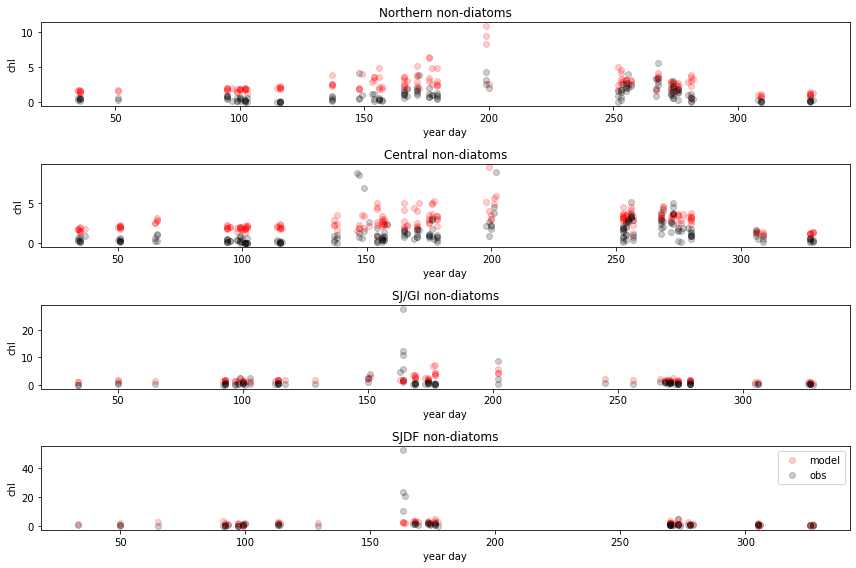

In [21]:
fig,ax=plt.subplots(4,1,figsize=(12,8))
r0=(data['mod_flagellates']>=0)&(data['mod_ciliates']>=0)&(data['other']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r2&r0; iax=ax[1]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r3&r0; iax=ax[2]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r4&r0;iax=ax[3]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')
iax.legend()

plt.tight_layout()

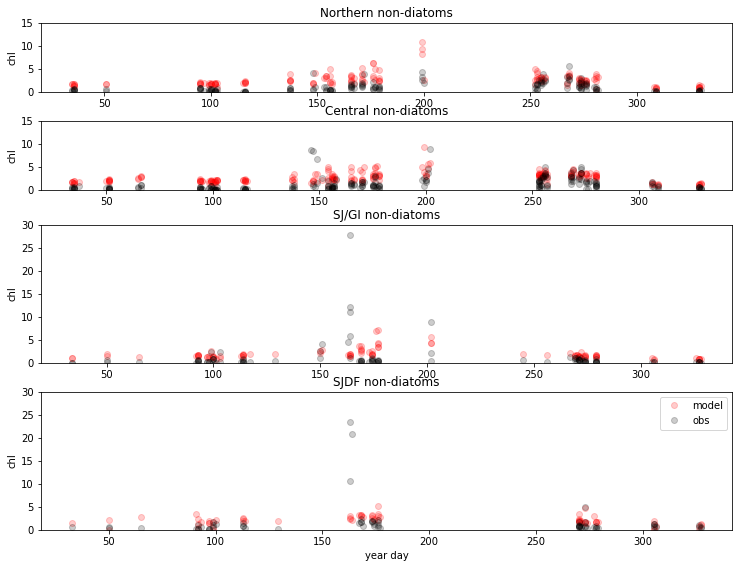

In [22]:
fig,ax=plt.subplots(4,1,figsize=(12,8))
r0=(data['mod_flagellates']>=0)&(data['mod_ciliates']>=0)&(data['other']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r2&r0; iax=ax[1]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r3&r0; iax=ax[2]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r4&r0;iax=ax[3]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')
iax.legend()

ax[0].set_ylim(0,15)
ax[1].set_ylim(0,15)
ax[2].set_ylim(0,30)
ax[3].set_ylim(0,30)
dy=.12
ax[0].set_position(pos=[0.1,.85,.8,dy])
ax[1].set_position(pos=[0.1,.68,.8,dy])
ax[2].set_position(pos=[0.1,.38,.8,dy*30/15])
ax[3].set_position(pos=[0.1,.09,.8,dy*30/15])

#plt.tight_layout()

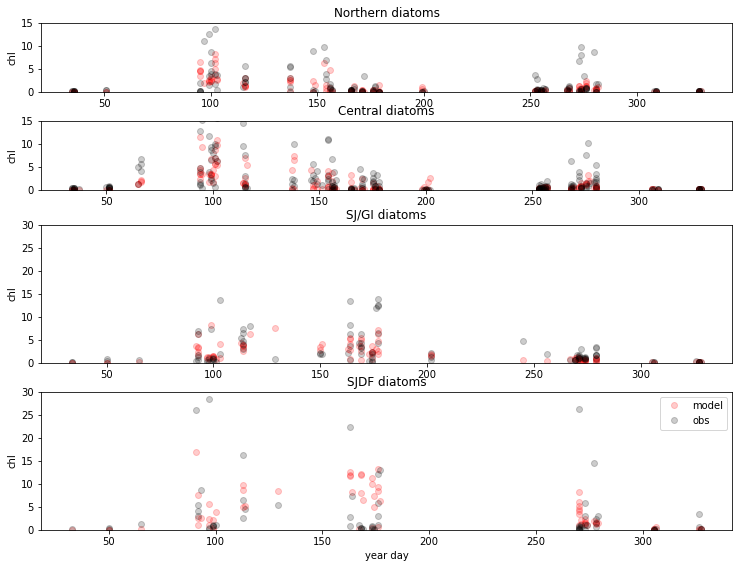

In [23]:
fig,ax=plt.subplots(4,1,figsize=(12,8))
r0=(data['mod_diatoms']>=0)&(data['Diatoms-1']>=0)&(data['Diatoms-2']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r2&r0; iax=ax[1]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r3&r0; iax=ax[2]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r4&r0;iax=ax[3]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_diatoms']].values)
yy2=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=.2,label='model')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=.2,label='obs')
iax.set_title(loc+' diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')
iax.legend()

ax[0].set_ylim(0,15)
ax[1].set_ylim(0,15)
ax[2].set_ylim(0,30)
ax[3].set_ylim(0,30)
dy=.12
ax[0].set_position(pos=[0.1,.85,.8,dy])
ax[1].set_position(pos=[0.1,.68,.8,dy])
ax[2].set_position(pos=[0.1,.38,.8,dy*30/15])
ax[3].set_position(pos=[0.1,.09,.8,dy*30/15])

#plt.tight_layout()

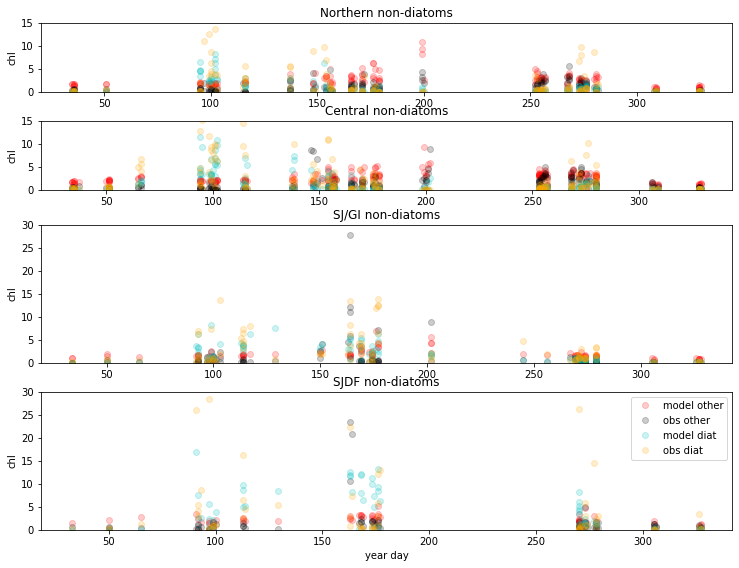

In [24]:
aval=.2
fig,ax=plt.subplots(4,1,figsize=(12,8))
r0=(data['mod_flagellates']>=0)&(data['mod_ciliates']>=0)&(data['other']>=0)
r1=(data.Lat>49.5)
r2=(data.Lat<49.5)&(data.Lat>48.8)
r3=(data.Lat<48.8)&(data.Lon>-123.5)
r4=(data.Lat<48.8)&(data.Lon<-123.5)
r=r1&r0; iax=ax[0]; loc='Northern'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
yy3=1.8*(data.loc[r,['mod_diatoms']].values)
yy4=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=aval,label='model other')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=aval,label='obs other')
iax.plot(xx[:,0],yy3[:,0],'co',alpha=aval,label='model diat')
iax.plot(xx[:,0],yy4[:,0],'o',color='orange',alpha=aval,label='obs diat')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r2&r0; iax=ax[1]; loc='Central'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
yy3=1.8*(data.loc[r,['mod_diatoms']].values)
yy4=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=aval,label='model other')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=aval,label='obs other')
iax.plot(xx[:,0],yy3[:,0],'co',alpha=aval,label='model diat')
iax.plot(xx[:,0],yy4[:,0],'o',color='orange',alpha=aval,label='obs diat')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r3&r0; iax=ax[2]; loc='SJ/GI'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
yy3=1.8*(data.loc[r,['mod_diatoms']].values)
yy4=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=aval,label='model other')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=aval,label='obs other')
iax.plot(xx[:,0],yy3[:,0],'co',alpha=aval,label='model diat')
iax.plot(xx[:,0],yy4[:,0],'o',color='orange',alpha=aval,label='obs diat')
iax.set_title(loc+' non-diatoms')
#iax.set_xlabel('year day')
iax.set_ylabel('chl')

r=r4&r0;iax=ax[3]; loc='SJDF'
xx=data.loc[r,['yd']].values
yy1=1.8*(data.loc[r,['mod_flagellates']].values+data.loc[r,['mod_ciliates']].values)
yy2=data.loc[r,['other']].values
yy3=1.8*(data.loc[r,['mod_diatoms']].values)
yy4=data.loc[r,['Diatoms-1']].values+data.loc[r,['Diatoms-2']].values
iax.plot(xx[:,0],yy1[:,0],'ro',alpha=aval,label='model other')
iax.plot(xx[:,0],yy2[:,0],'ko',alpha=aval,label='obs other')
iax.plot(xx[:,0],yy3[:,0],'co',alpha=aval,label='model diat')
iax.plot(xx[:,0],yy4[:,0],'o',color='orange',alpha=aval,label='obs diat')
iax.set_title(loc+' non-diatoms')
iax.set_xlabel('year day')
iax.set_ylabel('chl')
iax.legend()

ax[0].set_ylim(0,15)
ax[1].set_ylim(0,15)
ax[2].set_ylim(0,30)
ax[3].set_ylim(0,30)
dy=.12
ax[0].set_position(pos=[0.1,.85,.8,dy])
ax[1].set_position(pos=[0.1,.68,.8,dy])
ax[2].set_position(pos=[0.1,.38,.8,dy*30/15])
ax[3].set_position(pos=[0.1,.09,.8,dy*30/15])

#plt.tight_layout()

(-30, 25)

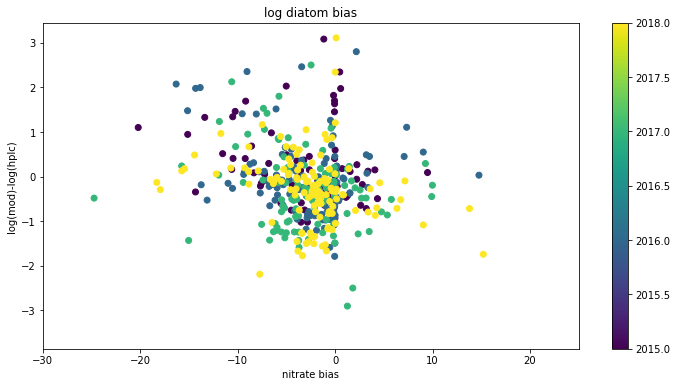

In [25]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['mod_nitrate']-data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('nitrate bias')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-30,25)

(-1, 30)

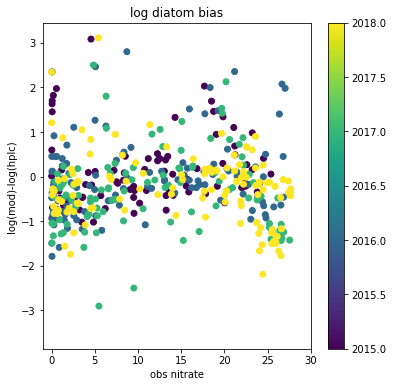

In [26]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs nitrate')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,30)

(-0.1, 3)

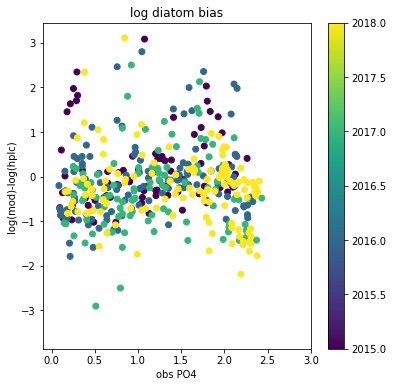

In [27]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Phosphate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs PO4')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-.1,3)

(-1, 70)

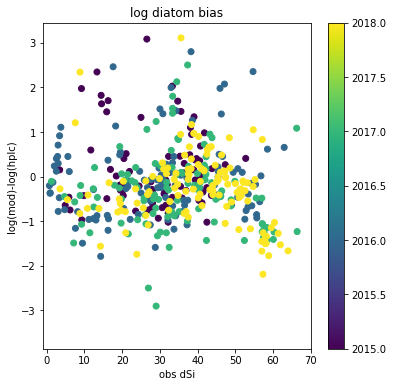

In [28]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Silicate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs dSi')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,70)